# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)
import sys
sys.path.append("../..")
# import matplotlib_utils
from importlib import reload
# reload(matplotlib_utils)
# import keras_utils
# from keras_utils import reset_tf_session

We're using TF 2.17.0


# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [3]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 7s 1us/step


X_train [shape (48000, 28, 28)] sample patch:
 [[  0  77 254 154   0]
 [  0 145 253  96   0]
 [  0 254 238  37   0]
 [  0 254 229   0   0]
 [  0 254 246  69   0]]
A closeup of a sample patch:


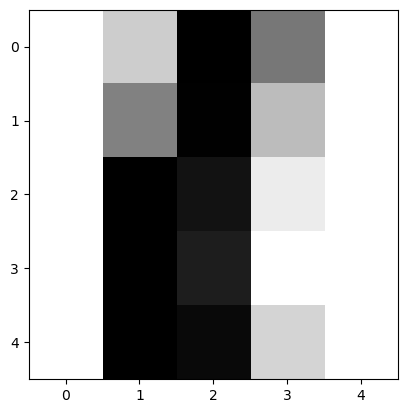

And the whole sample:


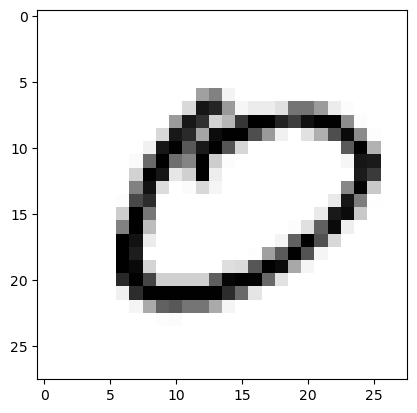

y_train [shape (48000,)] 10 samples:
 [5 0 1 6 1 3 8 8 1 8]


In [4]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

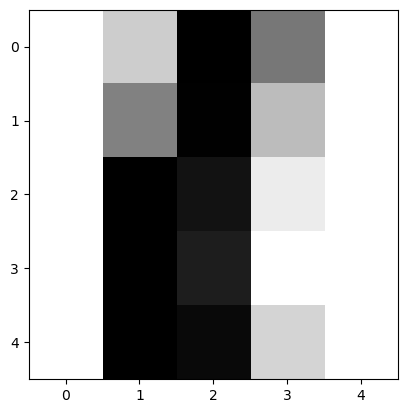

In [6]:
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()


And the whole sample:


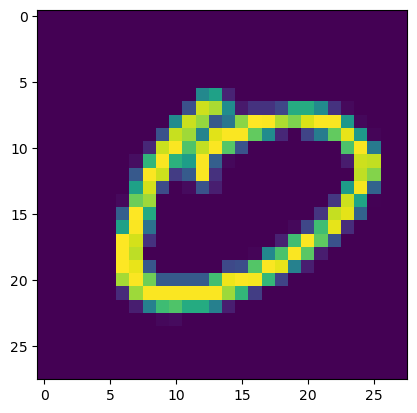

In [7]:
print("And the whole sample:")
plt.imshow(X_train[1], )
plt.show()


In [8]:
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

y_train [shape (48000,)] 10 samples:
 [5 0 1 6 1 3 8 8 1 8]


# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [9]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(48000, 784)
(12000, 784)


---------------------------------------------------------------------------

The One-hot = True argument only means that, in contrast to Binary representation, the labels will be presented in a way that only one bit will be on for a specific digit. For example, five and zero in a binary code would be:

In [10]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(48000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]] [5 0 1]


In [11]:
# run this again if you remake your graph
from tensorflow.keras import backend as K

K.clear_session()


# Assigning bias and weights to null tensors


Now we are going to create the weights and biases, for this purpose they will be used as arrays filled with zeros. The values that we choose here can be critical, but we'll cover a better way on the second part, instead of this type of initialization.

In [12]:


# Model parameters: W and b
w = tf.Variable(tf.random.normal(shape=[784, 10], stddev=0.01), name="weight")

# Define the bias variable initialized with zeros
b = tf.Variable(tf.zeros([1, 10]), name="base")

print(w)
print(b)

<tf.Variable 'weight:0' shape=(784, 10) dtype=float32, numpy=
array([[-0.00454196, -0.00981012, -0.00081141, ...,  0.01602454,
         0.01145409, -0.00897208],
       [-0.00988669,  0.0114821 , -0.00340666, ...,  0.00125506,
         0.00812974,  0.01330619],
       [ 0.00772642, -0.00536937,  0.0028296 , ...,  0.00793831,
         0.01153064, -0.00390545],
       ...,
       [-0.00070748,  0.0145832 , -0.01573669, ..., -0.00492242,
         0.01081907, -0.00336828],
       [ 0.00645773,  0.00356789, -0.00404242, ..., -0.0131298 ,
        -0.02253619,  0.00168513],
       [ 0.00038695,  0.00944066,  0.00327662, ..., -0.00755853,
        -0.01022889, -0.00651249]], dtype=float32)>
<tf.Variable 'base:0' shape=(1, 10) dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>


It's a best practice to create placeholders before variable assignments when using TensorFlow. Here we'll create placeholders for inputs ("Xs") and outputs ("Ys").

Placeholder 'X': represents the "space" allocated input or the images.

   * Each input has 784 pixels distributed by a 28 width x 28 height matrix   
   * The 'shape' argument defines the tensor size by its dimensions.  
   * 1st dimension = None. Indicates that the batch size, can be of any size.  
   * 2nd dimension = 784. Indicates the number of pixels on a single flattened MNIST image.  
Placeholder 'Y':_ represents the final output or the labels.

   * 10 possible classes (0,1,2,3,4,5,6,7,8,9)  
   * The 'shape' argument defines the tensor size by its dimensions.  
   * 1st dimension = None. Indicates that the batch size, can be of any size.   
   * 2nd dimension = 10. Indicates the number of targets/outcomes 
dtype for both placeholders: if you not sure, use tf.float32. The limitation here is that the later presented softmax function only accepts float32 or float64 dtypes

# Compute predictions

Adding Weights and Biases to input

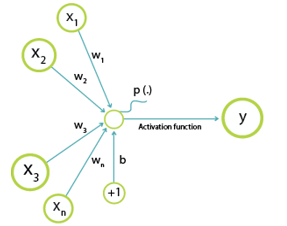
The only difference from our next operation to the picture below is that we are using the mathematical convention for what is being executed in the illustration. The tf.matmul operation performs a matrix multiplication between x (inputs) and W (weights) and after the code add biases.



Usually logits is the output tensor of a classification network, whose content is the unnormalized (not scaled between 0 and 1) probabilities.

Softmax Regression

Softmax is an activation function that is normally used in classification problems. It generate the probabilities for the output. For example, our model will not be 100% sure that one digit is the number nine, instead, the answer will be a distribution of probabilities where, if the model is right, the nine number will have the larger probability.

For comparison, below is the one-hot vector for a nine digit labe

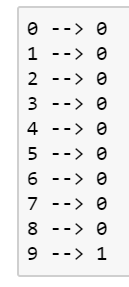

A machine does not have all this certainty, so we want to know what is the best guess, but we also want to understand how sure it was and what was the second better option. Below is an example of a hypothetical distribution for a nine digit:

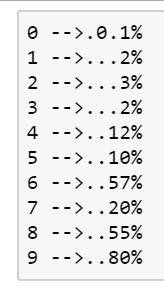

Logistic function output is used for the classification between two target classes 0/1. Softmax function is generalized type of logistic function. That is, Softmax can output a multiclass categorical probability distribution.

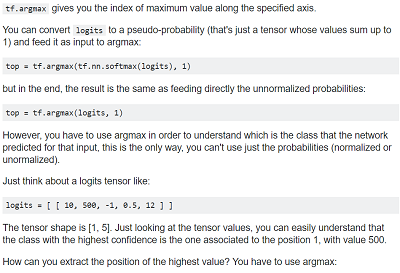

In [13]:
# probas=tf.nn.softmax(logits)
# classes=tf.argmax(logits,1)

 Use a default tf.train.AdamOptimizer to get an SGD step

In [40]:
# step=tf.train.AdamOptimizer(0.01).minimize(loss)

# Training batches

Train using minibatch Gradient Descent.

In practice, Batch Gradient Descent is not often used because is too computationally expensive. The good part about this method is that you have the true gradient, but with the expensive computing task of using the whole dataset in one time. Due to this problem, Neural Networks usually use minibatch to train.

from 1 to 40  this loop ?? withe 256 size of batch for all cycle 

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess data
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)).astype('float32') / 255

# Convert labels to one-hot encoded format
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Create the model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))

# Flatten the output
model.add(Flatten())

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(10, activation='softmax'))  # Output layer for classification

In [37]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Compile the model with the Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Training parameters
BATCH_SIZE = 64
EPOCHS = 10  # Reduced epochs for quick training

# Train the model with validation data
history = model.fit(X_train, y_train_oh, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_split=0.2,  # Use validation split instead of predefined validation set
                    verbose=1)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_oh, verbose=1)
print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.7738 - loss: 0.6983 - val_accuracy: 0.9790 - val_loss: 0.0679
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9651 - loss: 0.1239 - val_accuracy: 0.9851 - val_loss: 0.0536
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9779 - loss: 0.0770 - val_accuracy: 0.9877 - val_loss: 0.0455
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9828 - loss: 0.0595 - val_accuracy: 0.9877 - val_loss: 0.0441
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9854 - loss: 0.0480 - val_accuracy: 0.9883 - val_loss: 0.0434
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9883 - loss: 0.0414 - val_accuracy: 0.9901 - val_loss: 0.0400
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9897 - loss: 0.0353 - val_accuracy: 0.9893 - val_loss: 0.0412
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9903 - loss: 0.0308 - 

In [39]:
def get_random_indices(total_images, num_images):
    return np.random.choice(total_images, num_images, replace=False)

# Make predictions
predictions = model.predict(X_test)

# Reshape images to their original dimensions
X_test_images = X_test.reshape(-1, 28, 28)  # Assuming images are 28x28

# Get predicted classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test_oh, axis=1)




313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


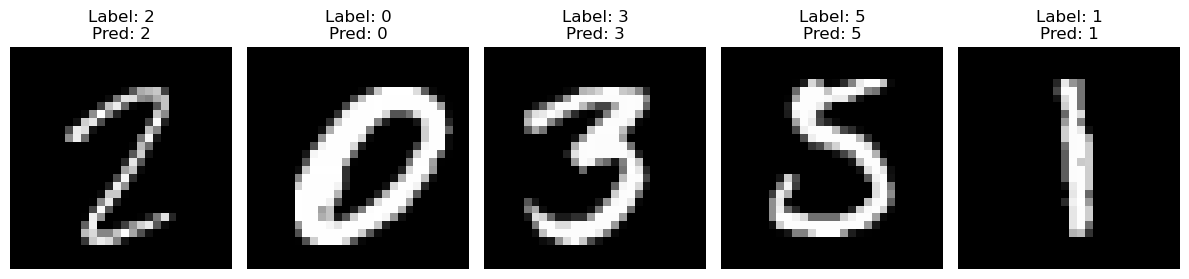

In [40]:

# Randomly select indices
num_images_to_show = 5
random_indices = get_random_indices(len(X_test_images), num_images_to_show)
# Plot and display images with predictions
def plot_images(images, labels, predictions):
    plt.figure(figsize=(12, 6))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i], cmap='gray')  # Assuming grayscale images
        plt.title(f'Label: {labels[i]}\nPred: {predictions[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display images with predictions
plot_images(X_test_images[random_indices], true_classes[random_indices], predicted_classes[random_indices])

# Adding more layers